### **Load libraries**

In [1]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import risk_kit as rk
import importlib

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.api import VAR

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### **Define ticker names**

In [4]:
col_stock_list_path = 'colombia_stocks_trii.csv'
global_stock_list_path = 'global_stocks_trii.csv'

ticker_list_col = list(pd.read_csv(col_stock_list_path, header=None)[0])
ticker_list_glob = list(pd.read_csv(global_stock_list_path, header=None)[0])

### **Extract data from YFinance**

In [5]:
# Define the number of periods per year for all calculations
# 252 is an approximation for daily
# 54 for weekly
# 12 for monthly
periods_per_year = 252

In [6]:
days_of_data = 1200 #790
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=days_of_data)

In [7]:
interval = '1d'   # Uncomment for daily data
#interval = '1wk'  # Uncomment for weekly data
# interval = '1mo' # Uncomment for monthly data

col_stocks_raw = yf.download(ticker_list_col, interval=interval, start=start_date, end=end_date, auto_adjust=True)['Close']
global_stocks_raw = yf.download(ticker_list_glob, interval=interval, start=start_date, end=end_date, auto_adjust=True)['Close']

[*********************100%***********************]  37 of 37 completed

3 Failed downloads:
['NUAMCO.CL']: YFInvalidPeriodError("NUAMCO.CL: Period 'max' is invalid, must be of the format 1d, 5d, etc.")
['GXTESCOL.CL']: YFInvalidPeriodError("GXTESCOL.CL: Period 'max' is invalid, must be of the format 1d, 5d, etc.")
['LTMCO.CL']: YFInvalidPeriodError("LTMCO.CL: Period 'max' is invalid, must be of the format 1d, 5d, etc.")
[*********************100%***********************]  48 of 49 completed

7 Failed downloads:
['IWVLM.XD']: YFInvalidPeriodError("IWVLM.XD: Period 'max' is invalid, must be of the format 1d, 5d, etc.")
['ENELAMCO.CL']: YFInvalidPeriodError("ENELAMCO.CL: Period 'max' is invalid, must be of the format 1d, 5d, etc.")
['LTMCO', 'IBO1', 'CFMITNIPCO']: YFTzMissingError('possibly delisted; no timezone found')
['ICHNA.XD']: YFInvalidPeriodError("ICHNA.XD: Period 'max' is invalid, must be of the format 1d, 5d, etc.")
['SQMBCO.CL']: YFInvalidPeriodError("SQMBCO.CL: Period 'max' is 

### **Preprocessing**

In [8]:
# Assign a frequency to the index of the dataframes
col_stocks_raw.index = col_stocks_raw.index.to_period(freq='D') # Uncomment to set frequency as Daily
global_stocks_raw.index = global_stocks_raw.index.to_period(freq='D') # Uncomment to set ferquency as Daily

# col_stocks_raw.index = col_stocks_raw.index.to_period(freq='W') # Uncomment to set frequency as Weekly
# global_stocks_raw.index = global_stocks_raw.index.to_period(freq='W') # Uncomment to set ferquency as Weekly

# col_stocks_raw.index = col_stocks_raw.index.to_period(freq='M') # Uncomment to set frequency as Monthly
# global_stocks_raw.index = global_stocks_raw.index.to_period(freq='M') # Uncomment to set frequency as Monthly

In [9]:
# Convert from prices into returns
col_rets_raw = col_stocks_raw.pct_change().iloc[1:]
global_rets_raw = global_stocks_raw.pct_change().iloc[1:]

C:\Users\jumar\AppData\Local\Temp\ipykernel_36028\959564986.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  col_rets_raw = col_stocks_raw.pct_change().iloc[1:]
C:\Users\jumar\AppData\Local\Temp\ipykernel_36028\959564986.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  global_rets_raw = global_stocks_raw.pct_change().iloc[1:]


In [10]:
# Define start and end dates of the analysis
days_of_analysis = 260*4   # Daily, 2 years
# days_of_analysis = 7*108   # Weekly, 2 years
end_date = str(datetime.date.today())
start_date = str(datetime.date.today() - datetime.timedelta(days=days_of_analysis))

In [11]:
# Merge Col and Global stock prices and returns data
rets = pd.concat([col_rets_raw, global_rets_raw], axis='columns').sort_index()
stocks = pd.concat([col_stocks_raw, global_stocks_raw], axis='columns').sort_index()
stocks = stocks.loc[:, rets.columns]

In [12]:
rets = rets.loc[start_date:end_date]
stocks = stocks.loc[start_date:end_date]

In [13]:
stocks_not_missing = stocks.columns[stocks.isna().sum() < stocks.shape[0]*.15]

In [14]:
rets = rets[stocks_not_missing].fillna(0)
stocks = stocks[stocks_not_missing].fillna(method='bfill')

C:\Users\jumar\AppData\Local\Temp\ipykernel_36028\2388026509.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stocks = stocks[stocks_not_missing].fillna(method='bfill')


In [316]:
# Generate train, validation and test sets to evaluate the accuracy of the model
# 1st The model will be modeled based on the train data initially
# 2nd The model will be fine tuned based on accuracy results with the validation set
# 3rd it will be evaluated with the test set

# train_rets = rets.iloc[:-24].copy()
# val_rets = rets.iloc[-24:-12].copy()
# test_rets = rets.iloc[-12:].copy()

train_set = rets.loc[: '2024-12'].copy()
test_set = rets.loc['2025-01':].copy()

### **Preprocessing - Analysis of stationarity**

In [327]:
# Analysis of stationarity for the whole series
for stock in rets.columns:
    print(f'Augmented Dickey Fuller Test p-value for non-stationarity of level {stock} series: {round(adfuller(train_set[stock].rolling(63).apply(lambda x: rk.annualize_returns(x, periods_per_year=252)).dropna())[1], 4)}')

Augmented Dickey Fuller Test p-value for non-stationarity of level BCOLOMBIA.CL series: 0.0334
Augmented Dickey Fuller Test p-value for non-stationarity of level BHI.CL series: 0.0391
Augmented Dickey Fuller Test p-value for non-stationarity of level BOGOTA.CL series: 0.0051
Augmented Dickey Fuller Test p-value for non-stationarity of level BVC.CL series: 0.0169
Augmented Dickey Fuller Test p-value for non-stationarity of level CELSIA.CL series: 0.3356
Augmented Dickey Fuller Test p-value for non-stationarity of level CEMARGOS.CL series: 0.0738
Augmented Dickey Fuller Test p-value for non-stationarity of level CNEC.CL series: 0.0041
Augmented Dickey Fuller Test p-value for non-stationarity of level CONCONCRET.CL series: 0.8622
Augmented Dickey Fuller Test p-value for non-stationarity of level CORFICOLCF.CL series: 0.0202
Augmented Dickey Fuller Test p-value for non-stationarity of level ECOPETROL.CL series: 0.0313
Augmented Dickey Fuller Test p-value for non-stationarity of level ENKA.

In [328]:
(rets.index.min(), rets.index.max())

(Period('2022-04-19', 'D'), Period('2025-02-21', 'D'))

<Axes: xlabel='Date'>

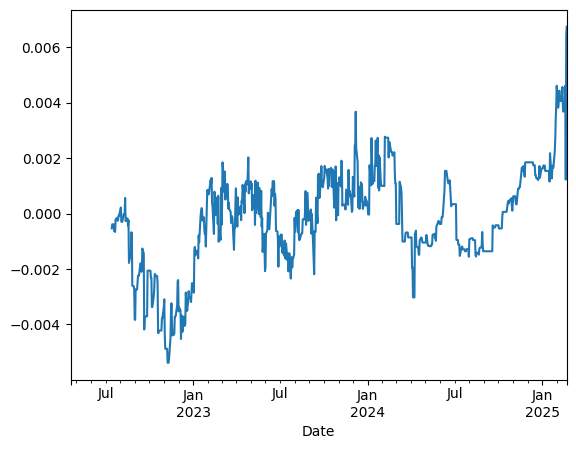

In [329]:
window_size = 21
rets['GRUPOAVAL.CL'].rolling(63).mean().plot()#.apply(lambda x: rk.annualize_returns(x, periods_per_year=252)).plot()
# rets['NVDA'].rolling(21).apply(rk.annualize_returns, args=(periods_per_year=252)).plot()
# rets['NVDA'].rolling(21).apply(lambda x: pd.Series(x+1).prod()**(1/window_size) - 1).plot()

### **Initial examination**

### **OLS model**

In [19]:
model_df = train_set[['NVDA']]

In [20]:
def ols_rets(stock, data, window_size=30, num_lag_windows=1, params=['mean']):
    model_df = data[[stock]].copy()
    for i in range(num_lag_windows):
        if 'mean' in params:
            model_df.loc[:, f'MA{window_size}_L{i+1}'] = model_df[stock].shift(1+(i*window_size)).rolling(window_size).apply(lambda x: pd.Series(x+1).prod()**(1/window_size) - 1)
            # model_df.loc[:, f'MA{window_size}_L{i+1}_squared'] = model_df[f'MA{window_size}_L{i+1}']**2
        if 'stddev' in params:
            model_df.loc[:, f'MStdDev{window_size}_L{i+1}'] = model_df[stock].shift(1+(i*window_size)).rolling(window_size).std(ddof=0)
    model_df.dropna(inplace=True)
    model = sm.OLS(endog=model_df[stock],
                   exog=sm.add_constant(model_df).drop(columns=[stock])).fit()
    return model

In [21]:
test_model = ols_rets('NVDA', train_set, window_size=126, num_lag_windows=4, params=['mean', 'stddev'])
print(test_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   NVDA   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.427
Date:                Sat, 22 Feb 2025   Prob (F-statistic):              0.187
Time:                        09:56:52   Log-Likelihood:                 412.27
No. Observations:                 202   AIC:                            -806.5
Df Residuals:                     193   BIC:                            -776.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1660      0.170      0.975

In [22]:
test_model = ols_rets('NVDA', train_set, window_size=21, num_lag_windows=12, params=['mean', 'stddev'])
print(test_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   NVDA   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     2.710
Date:                Sat, 22 Feb 2025   Prob (F-statistic):           3.22e-05
Time:                        09:56:55   Log-Likelihood:                 967.75
No. Observations:                 454   AIC:                            -1886.
Df Residuals:                     429   BIC:                            -1783.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1872      0.029      6.366

In [23]:
test_model = ols_rets('META', train_set, window_size=63, num_lag_windows=4, params=['mean', 'stddev'])
print(test_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   META   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.5809
Date:                Sat, 22 Feb 2025   Prob (F-statistic):              0.794
Time:                        09:57:03   Log-Likelihood:                 1107.0
No. Observations:                 454   AIC:                            -2196.
Df Residuals:                     445   BIC:                            -2159.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0043      0.012      0.347   

### **Predictions of moving averages**

In [119]:
def ols_ma_df(stock, data, window_size=30, num_lag_windows=1, params=['mean']):
    model_df = data[[stock]].copy()
    model_df[f'MA{window_size}_L{0}'] = model_df[stock].rolling(window_size).apply(lambda x: pd.Series(x+1).prod()**(1/window_size) - 1)
    for i in range(num_lag_windows+1):
        if 'mean' in params and i != 0:
            model_df.loc[:, f'MA{window_size}_L{i}'] = model_df[stock].shift(i*window_size).rolling(window_size).apply(lambda x: pd.Series(x+1).prod()**(1/window_size) - 1)
            model_df.loc[:, f'MA{window_size}_L{i}_squared'] = model_df[f'MA{window_size}_L{i}']**2
            model_df.loc[:, f'MA{window_size}_L{i}_cubed'] = model_df[f'MA{window_size}_L{i}']**3
            #model_df.loc[:, f'MA{window_size}_L{i}_power4'] = model_df[f'MA{window_size}_L{i}']**4
            #model_df.loc[:, f'MA{window_size}_L{i}_power5'] = model_df[f'MA{window_size}_L{i}']**5
            #model_df.loc[:, f'MA{window_size}_L{i}_power6'] = model_df[f'MA{window_size}_L{i}']**6
        if 'stddev' in params and i != 0:
            model_df.loc[:, f'MStdDev{window_size}_L{i}'] = model_df[stock].shift(i*window_size).rolling(window_size).std(ddof=0)
    model_df.dropna(inplace=True)
    endog = model_df[f'MA{window_size}_L0']
    exog = model_df.drop(columns=[f'MA{window_size}_L0', stock])
    return endog, exog

In [25]:
def ols_ma_rets(stock, data, window_size=30, num_lag_windows=1, params=['mean']):
    endog, exog = ols_ma_df(stock, data, window_size, num_lag_windows, params)
    model = sm.OLS(endog=endog,
                   exog=sm.add_constant(exog)).fit()
    return model

In [26]:
def ols_ma_predict(model, stock, data, window_size=30, num_lag_windows=1, params=['mean'], plot=False):
    endog, exog = ols_ma_df(stock, data, window_size, num_lag_windows, params)
    confidence_intervals = model.conf_int()
    lower_bound = (model_df * confidence_intervals.iloc[:, 0]).sum(axis=1)
    upper_bound = (model_df * confidence_intervals.iloc[:, 1]).sum(axis=1)
    preds = model.predict(model_df)

    if plot==True:
        plt.figure(figsize=(10, 5))
        # data[stock][-60:].plot(color='black', label='Actual returns')
        # data[stock].rolling(21).mean()[-60:].plot(color='blue', label=f'Actual MA{window_size}')
        preds.plot(color='orange', label=f'Predicted MA{window_size}')
        lower_bound.plot(color='grey', linestyle='--')
        upper_bound.plot(color='grey', linestyle='--')
        plt.legend()
        plt.grid(alpha=.3)
        plt.show()
        
    return preds, lower_bound, upper_bound

In [27]:
def ols_ma_predict_test_set(model, stock, train_set, test_set, window_size=30, num_lag_windows=1, params=['mean'], plot=False):
    data = pd.concat([train_set, test_set], axis=0)
    endog, exog = ols_ma_df(stock, data, window_size, num_lag_windows, params)
    exog = sm.add_constant(exog)
    confidence_intervals = model.conf_int()
    lower_bound = (exog * confidence_intervals.iloc[:, 0]).sum(axis=1)
    upper_bound = (exog * confidence_intervals.iloc[:, 1]).sum(axis=1)
    preds = model.predict(sm.add_constant(exog))
    actual_values = data[stock].rolling(window_size).apply(lambda x: pd.Series(x+1).prod()**(1/window_size) - 1)[test_set.index.min():]

    if plot==True:
        plt.figure(figsize=(10, 5))
        data[stock][-60:].plot(color='black', label='Actual returns')
        data[stock].rolling(window_size).apply(lambda x: pd.Series(x+1).prod()**(1/window_size) - 1)[-60:].plot(color='blue', label=f'Actual MA{window_size}')
        preds.loc[test_set.index.min():].plot(color='orange', label=f'Predicted MA{window_size}')
        lower_bound[test_set.index.min():].plot(color='grey', linestyle='--')
        upper_bound[test_set.index.min():].plot(color='grey', linestyle='--')
        plt.legend()
        plt.grid(alpha=.3)
        plt.show()
        
    return preds, lower_bound, upper_bound, actual_values

In [131]:
window_size = 63
model_test = ols_ma_rets('NVDA', train_set, window_size=window_size, num_lag_windows=4, params=['mean', 'stddev'])
print(model_test.summary())

                            OLS Regression Results                            
Dep. Variable:                MA63_L0   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     140.2
Date:                Sat, 22 Feb 2025   Prob (F-statistic):          3.47e-147
Time:                        10:46:26   Log-Likelihood:                 2085.8
No. Observations:                 392   AIC:                            -4138.
Df Residuals:                     375   BIC:                            -4070.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0123      0.001     

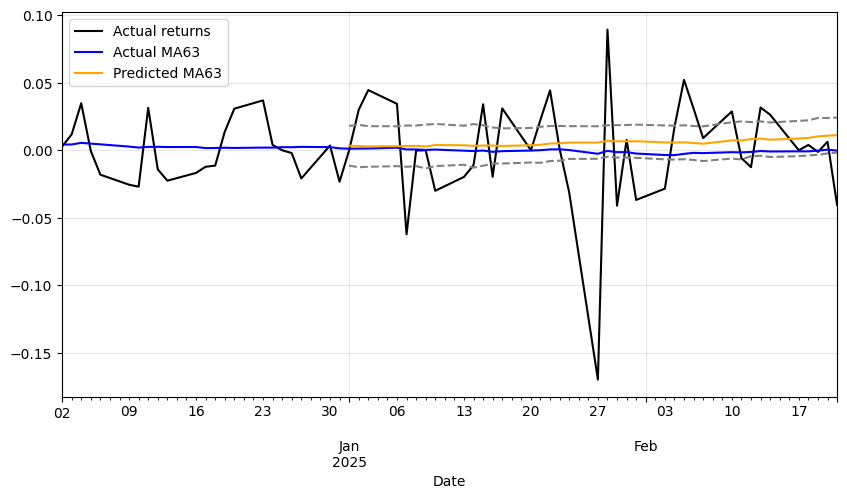

In [132]:
preds = ols_ma_predict_test_set(model_test, 'NVDA', train_set, test_set, window_size=window_size, num_lag_windows=4, params=['mean', 'stddev'], plot=True)

### **Score evaluation for different model specifications**

In [30]:
aic_scores = {}
log_likelihoods = {}
#for i in range(1, 127):
for i in [21, 42, 63, 84, 105, 126, 147, 168, 189, 210, 231]:
    window_size = i
    model_test = ols_ma_rets('GOOGL', train_set, window_size=window_size, num_lag_windows=2, params=['mean', 'stddev'])
    aic_scores[i] = model_test.aic
    log_likelihoods[i] = model_test.llf

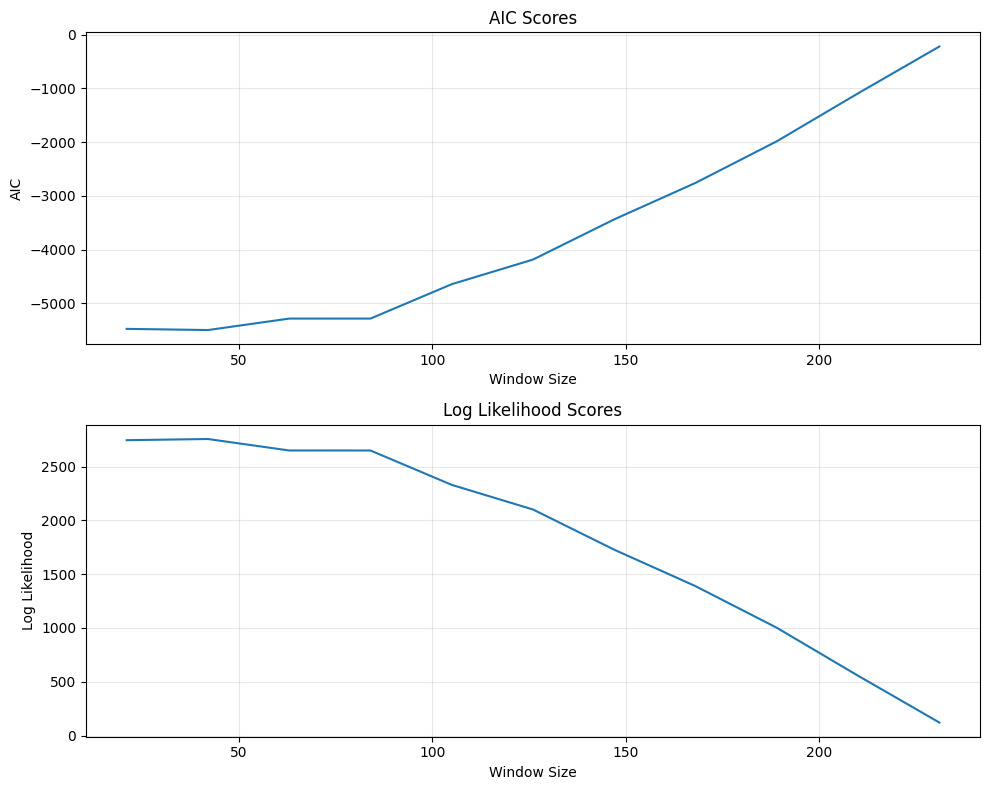

In [31]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
axes[0].plot(aic_scores.keys(), aic_scores.values())
axes[0].set_title('AIC Scores')
axes[0].set_xlabel('Window Size')
axes[0].set_ylabel('AIC')
axes[0].grid(alpha=.3)

axes[1].plot(log_likelihoods.keys(), log_likelihoods.values())
axes[1].set_title('Log Likelihood Scores')
axes[1].set_xlabel('Window Size')
axes[1].set_ylabel('Log Likelihood')
axes[1].grid(alpha=.3)

plt.tight_layout()
plt.show()

In [32]:
aic_scores = {}
log_likelihoods = {}
window_size=21
for i in range(0, 25):
    model_test = ols_ma_rets('META', train_set, window_size=window_size, num_lag_windows=i, params=['mean', 'stddev'])
    aic_scores[i] = model_test.aic
    log_likelihoods[i] = model_test.llf

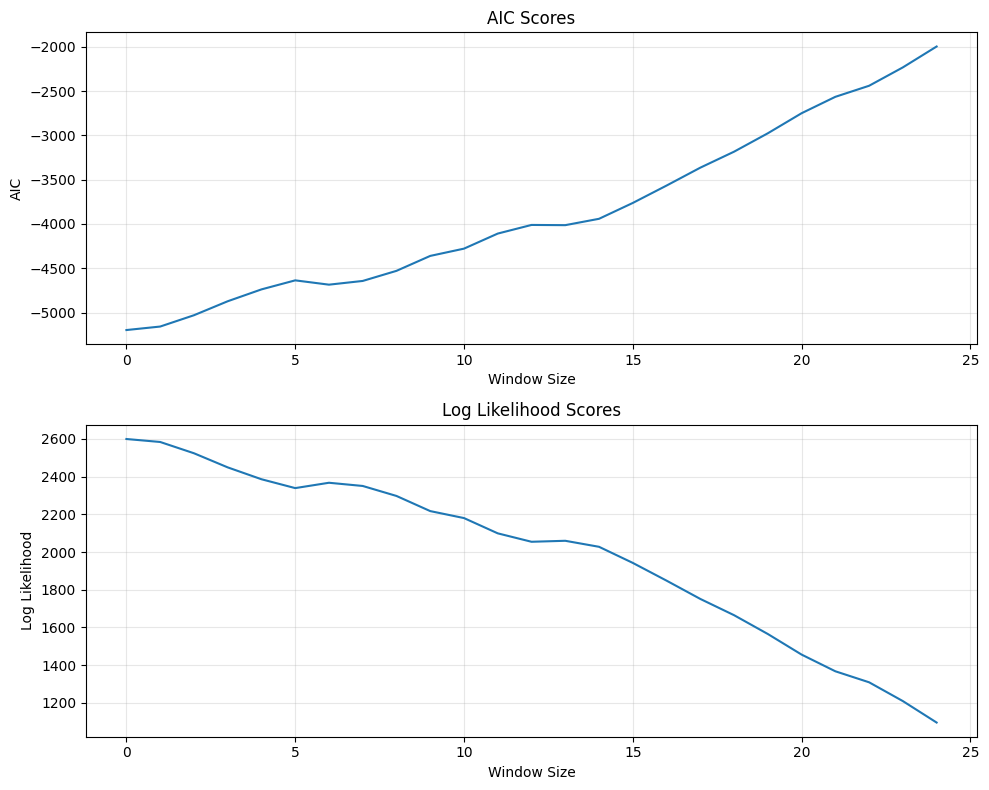

In [33]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
axes[0].plot(aic_scores.keys(), aic_scores.values())
axes[0].set_title('AIC Scores')
axes[0].set_xlabel('Window Size')
axes[0].set_ylabel('AIC')
axes[0].grid(alpha=.3)

axes[1].plot(log_likelihoods.keys(), log_likelihoods.values())
axes[1].set_title('Log Likelihood Scores')
axes[1].set_xlabel('Window Size')
axes[1].set_ylabel('Log Likelihood')
axes[1].grid(alpha=.3)

plt.tight_layout()
plt.show()

In [81]:
train_set.columns

Index(['BCOLOMBIA.CL', 'BHI.CL', 'BOGOTA.CL', 'BVC.CL', 'CELSIA.CL',
       'CEMARGOS.CL', 'CNEC.CL', 'CONCONCRET.CL', 'CORFICOLCF.CL',
       'ECOPETROL.CL', 'ENKA.CL', 'ETB.CL', 'EXITO.CL', 'GEB.CL',
       'GRUBOLIVAR.CL', 'GRUPOARGOS.CL', 'GRUPOAVAL.CL', 'GRUPOSURA.CL',
       'HCOLSEL.CL', 'ICOLCAP.CL', 'ISA.CL', 'MINEROS.CL', 'NUTRESA.CL',
       'PFAVAL.CL', 'PFBCOLOM.CL', 'PFCORFICOL.CL', 'PFDAVVNDA.CL',
       'PFGRUPOARG.CL', 'PFGRUPSURA.CL', 'PROMIGAS.CL', 'TERPEL.CL', 'AAPL',
       'AMZN', 'BAC', 'BRK-B', 'C', 'CBU7.L', 'CENCOSUD.SN', 'CHILE.SN',
       'CSPX.L', 'EIMI.L', 'F', 'FALABELLA.SN', 'GE', 'GOOGL', 'ISAC.CL',
       'IUFS.CL', 'IUIT.CL', 'JETS', 'JNJ', 'JPEA.CL', 'JPM', 'LQDA', 'META',
       'NKE', 'NU', 'NVDA', 'PBR', 'PFE', 'RBOT', 'SDHA.CL', 'SGLD.L',
       'SUAS.CL', 'UBER', 'VOO'],
      dtype='object', name='Ticker')

In [155]:
rmse = {}
mape = {}
rmse_naive = {}

window_size=63
num_lag_windows = 3

#window_sizes = [21, 42, 63, 84]#, 105, 126]
num_lag_windows = [i for i in range(1, 11)]
stock = 'ISA.CL'
for i in num_lag_windows:
    model_test = ols_ma_rets(stock, train_set, window_size=window_size, num_lag_windows=i, params=['mean', 'stddev'])
    preds_actuals = ols_ma_predict_test_set(model_test, stock, train_set, test_set, window_size=window_size, num_lag_windows=i, params=['mean', 'stddev'])
    preds = preds_actuals[0]['2025-01-01':]
    actuals = preds_actuals[3]

    naive = train_set.iloc[-504:][stock]
    rate = (1 + naive).prod()**(1/len(naive)) - 1

    rmse[i] = np.sqrt(np.mean((actuals - preds)**2))
    mape[i] = np.mean(np.abs((actuals - preds)/actuals))
    rmse_naive[i] = np.sqrt(np.mean((actuals - rate)**2))

C:\Python projects\Finance\lib\site-packages\statsmodels\regression\linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


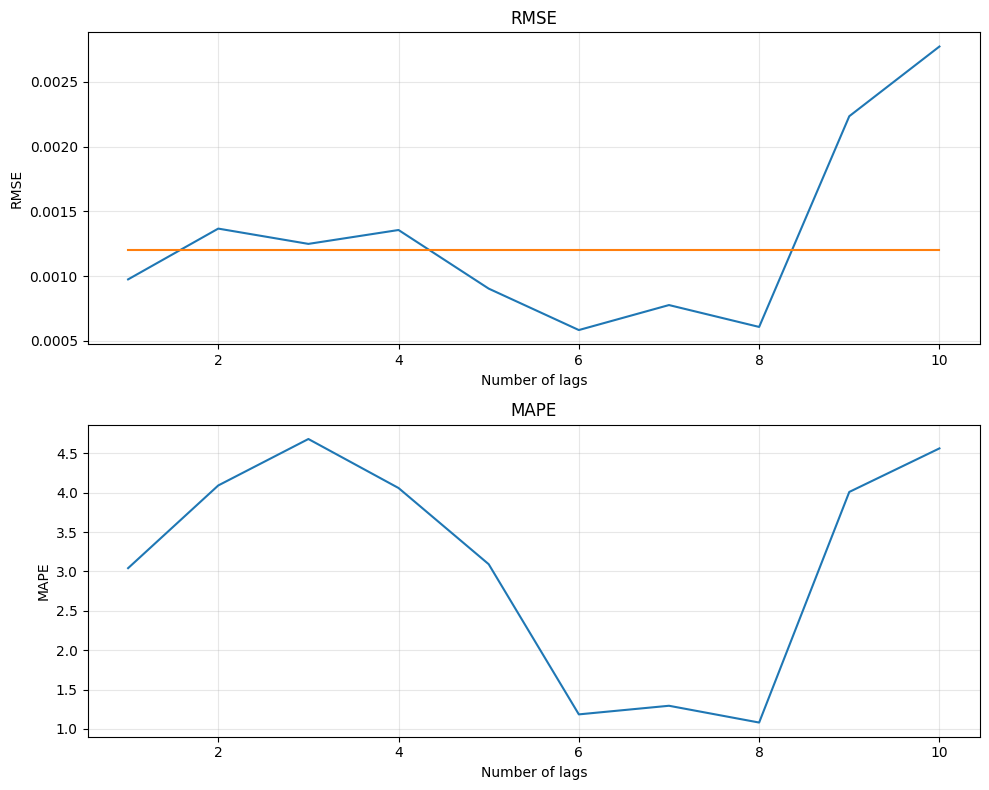

In [156]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
axes[0].plot(rmse.keys(), rmse.values())
axes[0].plot(rmse.keys(), rmse_naive.values())
axes[0].set_title('RMSE')
axes[0].set_xlabel('Number of lags')
axes[0].set_ylabel('RMSE')
axes[0].grid(alpha=.3)

axes[1].plot(mape.keys(), mape.values())
axes[1].set_title('MAPE')
axes[1].set_xlabel('Number of lags')
axes[1].set_ylabel('MAPE')
axes[1].grid(alpha=.3)

plt.tight_layout()
plt.show()

In [36]:
min_rmse_window = {}
min_mape_window = {}
#window_size=63
num_lag_windows = 1

window_sizes = [21, 42, 63]#[21, 42, 63, 84, 105, 126, 147, 168, 189, 210, 231]
num_lag_windows = [i for i in range(10)]
for stock in rets.columns:
    rmse_score = {}
    mape_score = {}
    for i in window_sizes:
        for j in num_lag_windows:
            try:
                model_test = ols_ma_rets(stock, train_set, window_size=i, num_lag_windows=j, params=['mean', 'stddev'])
                preds_actuals = ols_ma_predict_test_set(model_test, stock, train_set, test_set, window_size=i, num_lag_windows=j, params=['mean', 'stddev'])
                preds = preds_actuals[0]['2025-01-01':'2025-01-15']
                actuals = preds_actuals[3]['2025-01-01':'2025-01-15']
        
                rmse_score[f'{i}, {j}'] = np.sqrt(np.mean((actuals - preds)**2))
                mape_score[f'{i}, {j}'] = np.mean(np.abs((actuals - preds)/actuals))
                print(f'{stock} - Window_size: {i}, {j}')
            except:
                print(f'{stock} - Window_size: {i}, {j} - Error, not enough DF')
                continue
    min_rmse_window[f'{stock}, {i}, {j}'] = pd.Series(rmse_score).idxmin()
    min_mape_window[f'{stock}, {i}, {j}'] = pd.Series(mape_score).idxmin()

BCOLOMBIA.CL - Window_size: 21, 0
BCOLOMBIA.CL - Window_size: 21, 1
BCOLOMBIA.CL - Window_size: 21, 2
BCOLOMBIA.CL - Window_size: 21, 3
BCOLOMBIA.CL - Window_size: 21, 4
BCOLOMBIA.CL - Window_size: 21, 5
BCOLOMBIA.CL - Window_size: 21, 6
BCOLOMBIA.CL - Window_size: 21, 7
BCOLOMBIA.CL - Window_size: 21, 8
BCOLOMBIA.CL - Window_size: 21, 9
BCOLOMBIA.CL - Window_size: 42, 0
BCOLOMBIA.CL - Window_size: 42, 1
BCOLOMBIA.CL - Window_size: 42, 2
BCOLOMBIA.CL - Window_size: 42, 3
BCOLOMBIA.CL - Window_size: 42, 4
BCOLOMBIA.CL - Window_size: 42, 5
BCOLOMBIA.CL - Window_size: 42, 6
BCOLOMBIA.CL - Window_size: 42, 7
BCOLOMBIA.CL - Window_size: 42, 8
BCOLOMBIA.CL - Window_size: 42, 9
BCOLOMBIA.CL - Window_size: 63, 0
BCOLOMBIA.CL - Window_size: 63, 1
BCOLOMBIA.CL - Window_size: 63, 2
BCOLOMBIA.CL - Window_size: 63, 3
BCOLOMBIA.CL - Window_size: 63, 4
BCOLOMBIA.CL - Window_size: 63, 5
BCOLOMBIA.CL - Window_size: 63, 6
BCOLOMBIA.CL - Window_size: 63, 7
BCOLOMBIA.CL - Window_size: 63, 8
BCOLOMBIA.CL -

In [37]:
pd.DataFrame(columns=['Combination'], data=min_rmse_window.values(), index=pd.Series(min_rmse_window).index).groupby('Combination').value_counts().sort_values(ascending=False)

Combination
63, 8    11
63, 4     7
63, 5     6
63, 6     6
63, 0     6
63, 1     5
63, 7     4
42, 0     4
42, 9     3
42, 2     2
42, 7     2
63, 2     2
63, 3     2
21, 6     1
42, 8     1
42, 5     1
42, 1     1
63, 9     1
Name: count, dtype: int64

In [ ]:
pd.Series(min_rmse_window).plot(kind='hist')

In [ ]:
pd.Series(min_mape_window).plot(kind='hist')

In [ ]:
preds[3]

In [ ]:
preds[0]

In [ ]:
# https://www.youtube.com/watch?v=mm0DA8zgHIs

In [253]:
expected_annualized_rets = {}
rets_names = ['VOO']

# Generate train and test sets to find the best model for each stock
prediction_days = 63
train_set = rets.iloc[:-prediction_days]
test_set = rets.iloc[-prediction_days:]

window_size = 63
num_lag_windows = [l+1 for l in range(10)]

# Iterate over each stock
for stock in rets_names:#rets.columns:
    # Initialize an empty dictionary to store scores
    rmse = {}
    # Calculate the RMSE for a naive prediction against which other predictions will be compared
    naive = train_set[stock][-520:]
    naive_rets = (1 + naive).prod()**(1/len(naive)) - 1
    naive_rmse = np.sqrt(np.mean((test_set - naive_rets)**2))

    # Iterate over each amount of lag windows
    for i in range(1, 10):
        # Fit the model with the corresponding num_lag_windows parameter for the iteration
        model = ols_ma_rets(stock, train_set, window_size=window_size, num_lag_windows=i, params=['mean', 'stddev'])
        # Make predictions based on the test set we already have
        preds_actuals = ols_ma_predict_test_set(model, stock, train_set, test_set, window_size=window_size, num_lag_windows=i, params=['mean', 'stddev'])
        preds = preds_actuals[0][-prediction_days:]

        # Compare the predictions with the observed values
        rmse[i] = np.sqrt(np.mean((test_set[stock] - preds)**2))
    # Identify the best number of lags to use based on the RMSE
    best_lag_windows = pd.Series(rmse).idxmin()
    best_rmse = rmse[best_lag_windows]
    if best_rmse < naive_rmse:
        # If there was an RMSE better than the naive one, then make predictions with that model specification
        # First fit the model with all the data for the stock
        model = ols_ma_rets(stock, rets, window_size=window_size, num_lag_windows=best_lag_windows, params=['mean', 'stddev'])

        # Make a df with 63 future dates for the preprocessing function
        df_for_predict = rets.copy()
        future_dates = pd.date_range(start=df_for_predict.index.max().to_timestamp() + pd.Timedelta(days=1), periods=prediction_days)
        future_df = pd.DataFrame(index=future_dates, columns=rets.columns, data=0).to_period('D')
        df_for_predict = pd.concat([df_for_predict, future_df], axis=0)
        df_for_predict = sm.add_constant(ols_ma_df(stock, df_for_predict, window_size=window_size, num_lag_windows=best_lag_windows, params=['mean', 'stddev'])[1])
        # Compute the predictions
        future_preds = model.predict(df_for_predict)
        preds = (1 + future_preds[-1])**periods_per_year - 1
        # Extract the predictions for the average returns of the future days and store it in expected_daily_rets
        expected_annualized_rets[stock] = preds
    else:
        # If the models don't seem to perform better than just taking the returns from the last n days based on the analysis window
        historical = rets[stock][-520:]
        historical_rets = rk.annualize_returns(historical, periods_per_year=periods_per_year)
        expected_annualized_rets[stock] = historical_rets
        

C:\Users\jumar\AppData\Local\Temp\ipykernel_36028\1192176686.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preds = (1 + future_preds[-1])**periods_per_year - 1


In [254]:
(best_rmse, naive_rmse)

(0.00784322348618542, 0.02749996691378648)

In [ ]:
(best_rmse, naive_rmse)

In [208]:
best_lag_windows = 7
model = ols_ma_rets(stock, train_set, window_size=63, num_lag_windows=best_lag_windows, params=['mean', 'stddev'])
#model.summary()

In [223]:
df_for_predict = rets.copy()
future_dates = pd.date_range(start=df_for_predict.index.max().to_timestamp() + pd.Timedelta(days=1), periods=63)
future_df = pd.DataFrame(index=future_dates, columns=rets.columns, data=0).to_period('D')
df_for_predict = pd.concat([df_for_predict, future_df], axis=0)
df_for_predict = sm.add_constant(ols_ma_df(stock, df_for_predict, window_size=63, num_lag_windows=best_lag_windows, params=['mean', 'stddev'])[1])
preds = model.predict(df_for_predict)

<Axes: >

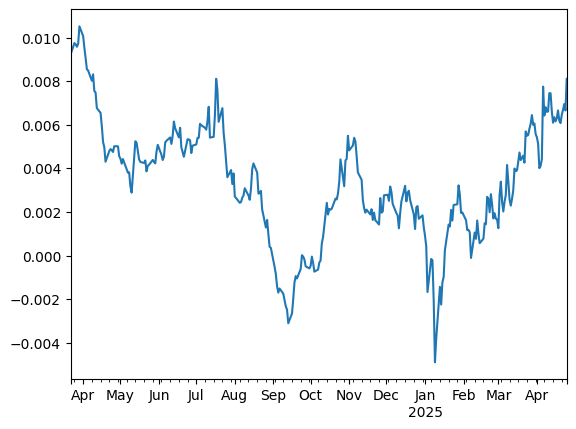

In [224]:
preds.plot()

In [ ]:
rmse = {}
mape = {}
rmse_naive = {}

window_size=63
num_lag_windows = 3

#window_sizes = [21, 42, 63, 84]#, 105, 126]
num_lag_windows = [i for i in range(1, 11)]
stock = 'ISA.CL'
for i in num_lag_windows:
    model_test = ols_ma_rets(stock, train_set, window_size=window_size, num_lag_windows=i, params=['mean', 'stddev'])
    preds_actuals = ols_ma_predict_test_set(model_test, stock, train_set, test_set, window_size=window_size, num_lag_windows=i, params=['mean', 'stddev'])
    preds = preds_actuals[0]['2025-01-01':]
    actuals = preds_actuals[3]

    naive = train_set.iloc[-504:][stock]
    rate = (1 + naive).prod()**(1/len(naive)) - 1

    rmse[i] = np.sqrt(np.mean((actuals - preds)**2))
    mape[i] = np.mean(np.abs((actuals - preds)/actuals))
    rmse_naive[i] = np.sqrt(np.mean((actuals - rate)**2))